# About

In [50]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text about organization of our code and this notebook

# Prerequisites 

This notebook expects you to have:
- stable internet access
- a Google identity
- configured a project under Google Cloud Platform (a description of how to do this, can be found [here](https://www.youtube.com/watch?v=i08S0KJLnyw))
- set "my_project_id" in the cell below to the ID of the GCP project you have configured under your account

In [2]:
my_project_id = "idc-pathomics-000"

# Environment setup

In [3]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /home/jupyter/idc-pathomics-use-case-1/src
Hostname          : idc-patho-vm
Username          : jupyter


In [4]:
!sudo apt-get update
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install -r ../requirements_cptac.txt # at the end, check whether all are required, maybe no requirement file needed, when only one/two things are installed
!pip install wandb -qqq # monitoring tool 

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease                            
Hit:3 http://deb.debian.org/debian buster-updates InRelease                    
Hit:4 http://deb.debian.org/debian buster-backports InRelease                  
Hit:5 https://download.docker.com/linux/debian buster InRelease                
Get:6 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease [1484 B]
Get:8 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease [1481 B]
Hit:9 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease         
Hit:10 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease
Get:11 https://packages.cloud.google.com/apt google-fast-socket InRelease [5405 B]
Hit:12 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Hit:7 https://packages.cloud.google.com/apt kubernetes-xenial InRelease
Hit:13 htt

In [198]:
# Import all required python libraries for this use case
import os
import sys
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide can not be loaded. Maybe find a better solution?!
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import wandb

In [6]:
# Create directories for input and output data 
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'
#os.mkdir(input_dir)
#os.mkdir(output_dir)

# Dataset selection and exploration

## Dataset selection using BigQuery

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `tbd` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place. Additional information on the organization of data can be found in the [IDC Documentation](https://learn.canceridc.dev/data/organization-of-data). 

The easiest way to acess BigQuery tables from within a Jupyter notebook is to use the [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) provided by the BigQuery client library for Python. 
Using the `%%bigquery` command as shown below, the results of the following SQL query are stored as pandas data frame `cohort_df`.   
Further information on how to use BigQuery within the IDC, on the attributes available and examples can be found [here](https://learn.canceridc.dev/cookbook/bigquery). 

In [8]:
%%bigquery cohort_df --project=$my_project_id 

WITH slide_images AS (
    SELECT
        ContainerIdentifier AS slide_id,
        PatientID AS patient_id,
        ClinicalTrialProtocolID AS dataset,
        TotalPixelMatrixColumns AS width,
        TotalPixelMatrixRows AS height,
        gcs_url,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
        CASE TransferSyntaxUID
            WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
            WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
            ELSE 'other'
        END AS compression
    FROM idc-dev-etl.idc_v3.dicom_all
    WHERE NOT (ContainerIdentifier IS NULL)
)
SELECT *
FROM slide_images
WHERE
    (compression = "jpeg")
    AND (dataset = "CPTAC-LUAD" OR dataset = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2211/2211 [00:01<00:00, 1444.15rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract those from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. 

In [19]:
from data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv(os.path.join(input_dir, 'tissue_type_data_TCIA.csv'))
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv for later use

## Dataset exploration 

Using pandas and matplotlib functionality the user can quite easily have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [18]:
print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'luad']) 
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'lscc'])
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

slides_metadata.head()

Total number of slides in this cohort:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


,slide_id,patient_id,cancer_subtype,tissue_type,width,height,gcs_url,pixel_spacing,compression
0,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,luad,tumor,55775,48446,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg
1,C3L-00095-26,C3L-00095,luad,normal,27887,24718,gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc42...,0.000494,jpeg
2,C3L-00412-21,C3L-00412,luad,tumor,33863,32867,gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4...,0.000494,jpeg
3,C3L-00568-23,C3L-00568,lscc,tumor,19919,18390,gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c...,0.000494,jpeg
4,C3L-00893-21,C3L-00893,luad,tumor,19919,19138,gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096...,0.000494,jpeg


Having ~1000 slides from ~200 patients for each cancer subtype, means that there are on average 5 WSI per patient. The left plot below provides more detailed information in form of a histogram. 

**Important:** From almost every patient (LUAD or LSCC), not only tumor tissue but both tumor tissue and healthy ("normal") tissue samples were collected. The right graph below reveals that in LUAD and LSCC, about one-third of the slides were derived from healthy tissue, while the other two-thirds were derived from cancer tissue. 

In [204]:
slides_metadata=pd.read_csv('/home/jupyter/idc_input/slides_metadata.csv')

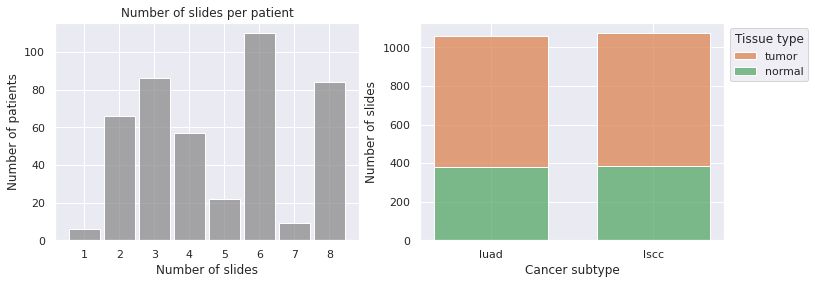

In [261]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# How many slides per patient? --> maybe also distinguish between luad and lscc pattients
slides_per_patient = slides_metadata.groupby(['patient_id', 'cancer_subtype']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.set_title('Number of slides per patient')
ax1.set_xlabel('Number of slides')
ax1.set_ylabel('Number of patients')

# Displaying tissue type distribution 
#print(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
plot2 = sns.histplot(data=slides_metadata, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C1', 'C2'], ax=ax2, shrink=0.7)
ax2.set_xlabel('Cancer subtype')
ax2.set_ylabel('Number of slides')
ax2.set_title('Distribution of tissue types')
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

In [ ]:
# IDC viewer for some pathomics data? 
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/" + study_UID

# Pathomics use case

In this use case, we solve a typical pathomics classification task by training a model to reliably distinguish between healthy tissue, LUAD tissue and LSCC tissue. 

(maybe show three tiles / another image from Coudray? / give sources / show workflow image)

## Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` and the respective "gcs_url"s. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file is created that reports the number of tiles created for each patient and is used to generate the figure below. \
As this code is supposed to serve as a demo requiring a minimum amount of runtime, we reduce each datasets size by taking only one in ten/twenty tiles. 

In [11]:
from data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
os.makedir(slides_dir)
os.makedir(tiles_dir)

generate_tiles(slides_dir, os.path.join(input_dir, 'slides_metadata.csv'), tiles_dir, 'idc-pathomics-000')

Reading input data from /home/jupyter/idc_input/cptac_slides


Copying gs://idc_dev/51036e43-5622-41a9-af03-603cf2127982.dcm...
\ [1 files][891.1 MiB/891.1 MiB]   67.4 MiB/s                                   
Operation completed over 1 objects/891.1 MiB.                                    


Processing: 93e30fd5-e57e-4503-a175-863c7d_D1_D1
here
there /home/jupyter/idc_input/cptac_slides/93e30fd5-e57e-4503-a175-863c7d_D1_D1.png
Slide 93e30fd5-e57e-4503-a175-863c7d_D1_D1 already tiled


Copying gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc421f5.dcm...
| [1 files][174.4 MiB/174.4 MiB]                                                
Operation completed over 1 objects/174.4 MiB.                                    


Processing: C3L-00095-26
here
there /home/jupyter/idc_input/cptac_slides/C3L-00095-26.png
Slide C3L-00095-26 already tiled


Copying gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4eba.dcm...
/ [1 files][260.1 MiB/260.1 MiB]                                                
Operation completed over 1 objects/260.1 MiB.                                    


Processing: C3L-00412-21
here
there /home/jupyter/idc_input/cptac_slides/C3L-00412-21.png
Slide C3L-00412-21 already tiled


Copying gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c90b.dcm...
- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


Processing: C3L-00568-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-00568-23.png
Slide C3L-00568-23 already tiled


Copying gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096848.dcm...
- [1 files][ 54.7 MiB/ 54.7 MiB]                                                
Operation completed over 1 objects/54.7 MiB.                                     


Processing: C3L-00893-21
here
there /home/jupyter/idc_input/cptac_slides/C3L-00893-21.png
Slide C3L-00893-21 already tiled


Copying gs://idc_dev/c4c93647-1e3d-48ea-9c3b-0f70fac797e0.dcm...
- [1 files][ 89.8 MiB/ 89.8 MiB]                                                
Operation completed over 1 objects/89.8 MiB.                                     


Processing: C3L-00913-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-00913-23.png
Slide C3L-00913-23 already tiled


Copying gs://idc_dev/fd572cef-6338-4f9a-bc90-14e0d0884674.dcm...
- [1 files][ 68.5 MiB/ 68.5 MiB]                                                
Operation completed over 1 objects/68.5 MiB.                                     


Processing: C3L-00923-26
here
there /home/jupyter/idc_input/cptac_slides/C3L-00923-26.png
Slide C3L-00923-26 already tiled


Copying gs://idc_dev/889622c2-c80b-45f4-84c2-323e893bdfa7.dcm...
| [1 files][170.1 MiB/170.1 MiB]                                                
Operation completed over 1 objects/170.1 MiB.                                    


Processing: C3L-00973-28
here
Some processing error for slide C3L-00973-28


Copying gs://idc_dev/22dff2ee-46d4-4454-ad32-c1a1928c7614.dcm...
\ [1 files][121.8 MiB/121.8 MiB]                                                
Operation completed over 1 objects/121.8 MiB.                                    


Processing: C3L-01606-21
here
Some processing error for slide C3L-01606-21


Copying gs://idc_dev/b10bee93-bc51-4a8d-b9dc-baca5813a3a1.dcm...
\ [1 files][334.3 MiB/334.3 MiB]                                                
Operation completed over 1 objects/334.3 MiB.                                    


Processing: C3L-02168-25
here
there /home/jupyter/idc_input/cptac_slides/C3L-02168-25.png
Slide C3L-02168-25 already tiled


Copying gs://idc_dev/0bb9925c-baef-44e9-905d-169e8aff7c13.dcm...
- [1 files][316.0 MiB/316.0 MiB]                                                
Operation completed over 1 objects/316.0 MiB.                                    


Processing: C3L-02169-26
here
there /home/jupyter/idc_input/cptac_slides/C3L-02169-26.png
Slide C3L-02169-26 already tiled


Copying gs://idc_dev/a662782f-eed7-4117-a714-9906e554a5ca.dcm...
| [1 files][950.3 MiB/950.3 MiB]   72.2 MiB/s                                   
Operation completed over 1 objects/950.3 MiB.                                    


Processing: C3L-02170-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-02170-23.png
Slide C3L-02170-23 already tiled


Copying gs://idc_dev/3b133086-1656-4f37-ad73-5e171b51486c.dcm...
- [1 files][ 53.3 MiB/ 53.3 MiB]                                                
Operation completed over 1 objects/53.3 MiB.                                     


Processing: C3L-02219-22
here
there /home/jupyter/idc_input/cptac_slides/C3L-02219-22.png
Slide C3L-02219-22 already tiled


Copying gs://idc_dev/1f4d7b59-ab92-4b3f-95c5-dd439df59047.dcm...
\ [1 files][120.2 MiB/120.2 MiB]                                                
Operation completed over 1 objects/120.2 MiB.                                    


Processing: C3L-02219-21
here
there /home/jupyter/idc_input/cptac_slides/C3L-02219-21.png
Slide C3L-02219-21 already tiled


Copying gs://idc_dev/9f392a0f-1853-44bb-bbc8-f4ceaa6fbd37.dcm...
- [1 files][ 84.3 MiB/ 84.3 MiB]                                                
Operation completed over 1 objects/84.3 MiB.                                     


Processing: C3L-02508-22
here
there /home/jupyter/idc_input/cptac_slides/C3L-02508-22.png
Slide C3L-02508-22 already tiled


Copying gs://idc_dev/bac28122-4563-41be-b072-ca4261ddcfed.dcm...
- [1 files][ 54.2 MiB/ 54.2 MiB]                                                
Operation completed over 1 objects/54.2 MiB.                                     


Processing: C3L-02546-26
here
there /home/jupyter/idc_input/cptac_slides/C3L-02546-26.png
Slide C3L-02546-26 already tiled


Copying gs://idc_dev/056a0877-3093-4f7f-a0a7-c4479830aa9c.dcm...
- [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     


Processing: C3L-02552-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-02552-23.png
Slide C3L-02552-23 already tiled


Copying gs://idc_dev/39209635-61fd-4f58-a897-b8466a5f80d1.dcm...
\ [1 files][133.5 MiB/133.5 MiB]                                                
Operation completed over 1 objects/133.5 MiB.                                    


Processing: C3L-02619-26
here
there /home/jupyter/idc_input/cptac_slides/C3L-02619-26.png
Slide C3L-02619-26 already tiled


Copying gs://idc_dev/b8e15005-14bd-4c2b-83c6-fe6e63daff42.dcm...
/ [1 files][236.6 MiB/236.6 MiB]                                                
Operation completed over 1 objects/236.6 MiB.                                    


Processing: C3L-02627-27
here
there /home/jupyter/idc_input/cptac_slides/C3L-02627-27.png
Slide C3L-02627-27 already tiled


Copying gs://idc_dev/2457f37d-3679-4a90-b080-967985a680c0.dcm...
/ [1 files][435.4 MiB/435.4 MiB]                                                
Operation completed over 1 objects/435.4 MiB.                                    


Processing: C3L-02643-21
here
there /home/jupyter/idc_input/cptac_slides/C3L-02643-21.png
Slide C3L-02643-21 already tiled


Copying gs://idc_dev/ec855abe-90ec-4bcc-9106-d397de34738f.dcm...
/ [1 files][217.8 MiB/217.8 MiB]                                                
Operation completed over 1 objects/217.8 MiB.                                    


Processing: C3L-02661-23
here
Some processing error for slide C3L-02661-23


Copying gs://idc_dev/ec2c0ca2-e9d0-4df1-a1fb-44eea6b35909.dcm...
\ [1 files][300.1 MiB/300.1 MiB]                                                
Operation completed over 1 objects/300.1 MiB.                                    


Processing: C3L-02669-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-02669-23.png
Slide C3L-02669-23 already tiled


Copying gs://idc_dev/0e1073ff-b089-40b6-a59a-f8150f57664e.dcm...
- [1 files][ 82.0 MiB/ 82.0 MiB]                                                
Operation completed over 1 objects/82.0 MiB.                                     


Processing: C3L-02834-23
here
there /home/jupyter/idc_input/cptac_slides/C3L-02834-23.png
Slide C3L-02834-23 already tiled


Copying gs://idc_dev/cd739761-2469-4935-9e74-b5f5823cda31.dcm...


KeyboardInterrupt: 

In [24]:
from data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_luad_lscc')

Total number of tiles: 3,592,912


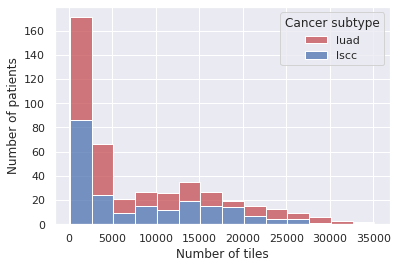

In [264]:
# How many tiles per patient (due to different size of slides)?
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig2 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', binwidth=2500, palette=['r', 'b'])
fig2.set_xlabel('Number of tiles')
fig2.set_ylabel('Number of patients')
legend = fig2.get_legend()
legend.set_title('Cancer subtype')

In [144]:
# Create smaller training / validation and test sets (1/10 of the tiles) --> final adaptation required!
!sed -n '1p;0~10p' "$input_dir/train_norm_luad_lscc.csv" > "$input_dir/train_norm_luad_lscc_medium.csv"
!sed -n '1p;0~10p' "$input_dir/valid_norm_luad_lscc.csv" > "$input_dir/valid_norm_luad_lscc_medium.csv"
!sed -n '1p;0~10p' "$input_dir/test_norm_luad_lscc.csv" > "$input_dir/test_norm_luad_lscc_medium.csv"

## Training

**Network training**: Following Coudray and colleagues, we use the InceptionV3 network architecture as implemented by Keras and shown in the figure below. The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves.  

In [145]:
# add image from network

In [265]:
wandb.login()
run = wandb.init()

2021-08-18 16:19:46.036608: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-18 16:19:47.126876: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer.so.7
2021-08-18 16:19:47.132596: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer_plugin.so.7



InvalidVersionSpec: Invalid version '1.0<2': invalid character(s)



In [266]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_smaller.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_smaller.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

Train for 243 steps, validate for 54 steps
Epoch 1/10
243/243 [==============================] - 330s 1s/step - loss: 0.9363 - auc_1: 0.8150 - val_loss: 1.3463 - val_auc_1: 0.6265
Epoch 2/10
242/243 [============================>.] - ETA: 1s - loss: 0.7234 - auc_1: 0.8620

2021-08-18 16:29:42.963041: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_002/assets
243/243 [==============================] - 314s 1s/step - loss: 0.7230 - auc_1: 0.8621 - val_loss: 0.7434 - val_auc_1: 0.8537
Epoch 3/10
242/243 [============================>.] - ETA: 1s - loss: 0.6455 - auc_1: 0.8871

2021-08-18 16:34:56.381967: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_003/assets
243/243 [==============================] - 317s 1s/step - loss: 0.6453 - auc_1: 0.8872 - val_loss: 0.7704 - val_auc_1: 0.8376
Epoch 4/10
242/243 [============================>.] - ETA: 1s - loss: 0.6129 - auc_1: 0.8981

2021-08-18 16:40:14.207241: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_004/assets
243/243 [==============================] - 316s 1s/step - loss: 0.6128 - auc_1: 0.8981 - val_loss: 0.6372 - val_auc_1: 0.8921
Epoch 5/10
242/243 [============================>.] - ETA: 1s - loss: 0.5853 - auc_1: 0.9071

2021-08-18 16:45:27.666282: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_005/assets
243/243 [==============================] - 315s 1s/step - loss: 0.5851 - auc_1: 0.9072 - val_loss: 0.6734 - val_auc_1: 0.8762
Epoch 6/10
242/243 [============================>.] - ETA: 1s - loss: 0.5524 - auc_1: 0.9164

2021-08-18 16:50:41.960759: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_006/assets
243/243 [==============================] - 312s 1s/step - loss: 0.5523 - auc_1: 0.9165 - val_loss: 0.6298 - val_auc_1: 0.8915
Epoch 7/10
242/243 [============================>.] - ETA: 1s - loss: 0.5291 - auc_1: 0.9233

2021-08-18 16:55:53.645118: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_007/assets
243/243 [==============================] - 314s 1s/step - loss: 0.5290 - auc_1: 0.9234 - val_loss: 0.7583 - val_auc_1: 0.8393
Epoch 8/10
242/243 [============================>.] - ETA: 1s - loss: 0.5098 - auc_1: 0.9288

2021-08-18 17:01:06.766472: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_008/assets
243/243 [==============================] - 310s 1s/step - loss: 0.5099 - auc_1: 0.9288 - val_loss: 0.5649 - val_auc_1: 0.9133
Epoch 9/10
242/243 [============================>.] - ETA: 1s - loss: 0.4932 - auc_1: 0.9336

2021-08-18 17:06:17.501693: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_009/assets
243/243 [==============================] - 314s 1s/step - loss: 0.4933 - auc_1: 0.9336 - val_loss: 0.5760 - val_auc_1: 0.9144
Epoch 10/10
242/243 [============================>.] - ETA: 1s - loss: 0.4774 - auc_1: 0.9372

2021-08-18 17:11:31.115845: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210818_161953/checkpoint_010/assets
243/243 [==============================] - 314s 1s/step - loss: 0.4773 - auc_1: 0.9373 - val_loss: 0.7308 - val_auc_1: 0.8669


2021-08-18 17:12:33.064179: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2021-08-18 17:12:33.070001: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


In [267]:
run.finish()

## Evaluation

explanatory text, explain ROC analysis? micro average.../ slide-based average probability/percentage positive 

In [268]:
#checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
#checkpoints.sort()
#best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
from model.inceptionv3_model import InceptionModel
from data.data_set import Dataset
output_dir_experiment='/home/jupyter/idc_output/20210818_161953/'
best_model_dir = '/home/jupyter/idc_output/20210818_161953/checkpoint_008'
best_model = InceptionModel.load(best_model_dir)

In [ ]:
from evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_small.csv'), num_classes=3)
predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_testset_small.json'))

tile-based                                            \
                                                              
              auc                                confidence   
Normal   0.908872  [0.9048882277011108, 0.9126389463550317]   
LUAD     0.848867   [0.844148006201662, 0.8531464239102744]   
LUSC     0.857335  [0.8525412380917878, 0.8620733704241026]   
Micro    0.872817  [0.8703269795094752, 0.8755047982833484]   
Macro    0.871691                                       NaN   

               slide-based                                            \
       average probability                                             
                       auc                                confidence   
Normal            0.968394  [0.9444346755758748, 0.9867204496011603]   
LUAD              0.868591  [0.8248214095319331, 0.9076781459822395]   
LUSC              0.897563  [0.8604513604513604, 0.9314285714285714]   
Micro             0.913019  [0.8926495061488253, 0.9301169276979191]   
Macro             0.913281                                       NaN   

                                                                      
       percentage positive                                            
                       auc                                confidence  
Normal            0.955275  [0.9223394495412844, 0.9829971314888498]  
LUAD              0.858826  [0.8160112359550562, 0.9000228414801277]  
LUSC              0.895397  [0.8551600735080762, 0.9297385620915033]  
Micro              0.90386  [0.8805180620761606, 0.9244890835237369]  
Macro             0.904372                                       NaN

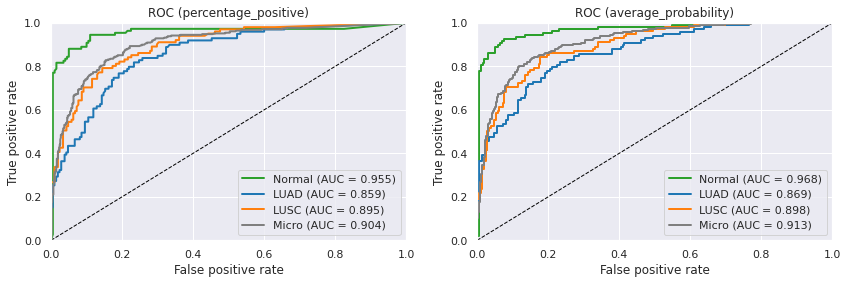

In [272]:
from evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions, experiment='norm_luad_lusc')
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table_small.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 265.5, -0.5)

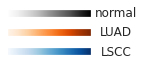

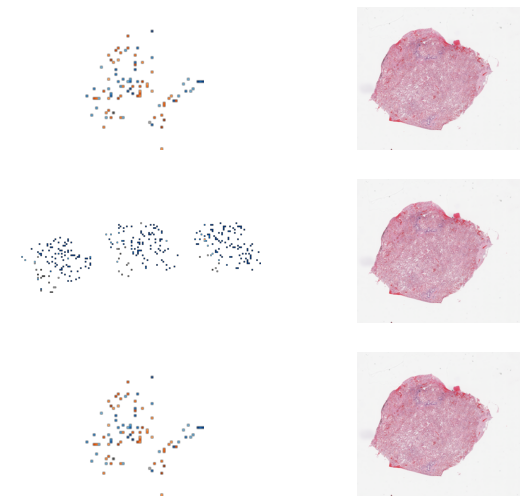

In [233]:
from evaluation.heatmap import get_heatmap, plot_colormap_legend
from evaluation.predictions import Predictions

import matplotlib
predictions = Predictions.load('/home/jupyter/idc_output/20210816_125633/predictions_testset_tiny.json')

slide1 = plt.imread('/home/jupyter/idc_input/cptac_slides/C3L-00095-26.png')
slide2 = plt.imread('/home/jupyter/idc_input/cptac_slides/C3L-00095-26.png')
slide3 = plt.imread('/home/jupyter/idc_input/cptac_slides/C3L-00095-26.png')
plot_colormap_legend()

fig3, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 9))
ax1.imshow(get_heatmap(predictions, 'C3L-00913-22'))
ax1.axis('off')
ax2.imshow(slide1)
ax2.axis('off')
ax3.imshow(get_heatmap(predictions, 'C3L-04873-21'))
ax3.axis('off')
ax4.imshow(slide2)
ax4.axis('off')
ax5.imshow(get_heatmap(predictions, 'C3L-00913-22'))
ax5.axis('off')
ax6.imshow(slide3)
ax6.axis('off')

## Notes for improvement
- vielleicht ueberall funktionsparameter benennen zur besseren verstaendlichkeit**
- suppress warnings that we don't want the user to see all the time
- State some final remarks in this notebook? 
- Skip micro/macro averaging for this use case?
- no confidence interval computation? 
- remove make_single_prediction?
- remove wandb.logger from code 
- How many details about lr etc in code? 
- keep colors consistent (introduce in the beginning) 
- weniger Betonung auf Coudray? 
- comments about how long tile generation lasts 